## GBM для передбачення академічної успішності.

Працюватиметмо з даними про успішність учнів португальської школи (джерело: UCI Machine Learning Repository). Для кожного учня задані такі атрибути, як освіта батьків, розмір сім’ї, показники відвідування, деталі особистого життя та багато інших.
Використаємо популярні бібліотеки pandas, scikit-learn та XGBoost, щоб побудувати ансамбль із регресійних дерев і передбачити оцінку учня на фінальному іспиті з математики. Також, визначимо, які ознаки модель вважає найважливішими для передбачення.

#### Імпортування необхідних бібліотек 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Заватнаження данних

In [2]:
students = pd.read_csv('student-mat.csv', sep=';')
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


#### Застосуємо one-hot encoding для категоріальних змінних

In [3]:
students_train = pd.get_dummies(students, columns=['school', 'sex', 'address','famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian'])

#### Закодуємо бінарні ознаки як 1/0

In [4]:
le = preprocessing.LabelEncoder()
def to_binary_columns(columns):
    for column in columns:
        le.fit(students_train[column])
        students_train[column] = le.transform(students_train[column])
        
binary_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
to_binary_columns(binary_columns)

#### Вилучимо колонки G1, G2, G3. Колонку G3 будемо передбачати

In [5]:
del students_train['G1']
del students_train['G2']
del students_train['G3']

In [6]:
print(students_train.dtypes)

age                  int64
Medu                 int64
Fedu                 int64
traveltime           int64
studytime            int64
failures             int64
schoolsup            int64
famsup               int64
paid                 int64
activities           int64
nursery              int64
higher               int64
internet             int64
romantic             int64
famrel               int64
freetime             int64
goout                int64
Dalc                 int64
Walc                 int64
health               int64
absences             int64
school_GP            uint8
school_MS            uint8
sex_F                uint8
sex_M                uint8
address_R            uint8
address_U            uint8
famsize_GT3          uint8
famsize_LE3          uint8
Pstatus_A            uint8
Pstatus_T            uint8
Mjob_at_home         uint8
Mjob_health          uint8
Mjob_other           uint8
Mjob_services        uint8
Mjob_teacher         uint8
Fjob_at_home         uint8
F

#### Розділимо дані в пропорції 90%:10% для навчання та тестування

In [7]:
train_X,test_X = train_test_split(students_train, test_size=0.1, random_state=42)
train_y,test_y = train_test_split(students['G3'], test_size=0.1, random_state=42)

#### Hатренуємо XGBRegressor на 200 дерев із максимальною глибиною 4, learning rate 0.05

In [8]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, seed=42).fit(train_X, train_y)

#### Використовуючи тестову вибірку, обчислимо середню похибку передбачення (MAE).

In [9]:
predicted_test =  xgb_model.predict(test_X);
mae = mean_absolute_error(test_y, predicted_test)
print('Cередня похибка передбачення (MAE):', mae)

Cередня похибка передбачення (MAE): 3.25385516882


#### Побудуємо residual plot (графік різниці між передбаченими та істинними значеннями)

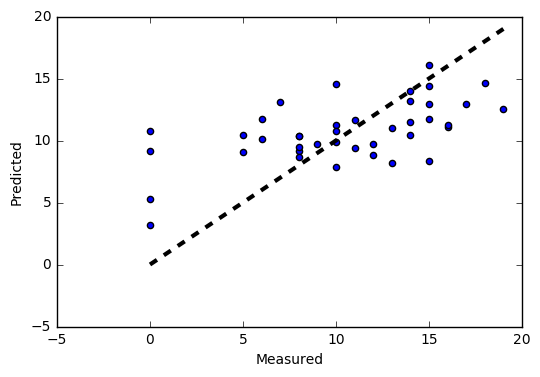

In [10]:
fig, ax = plt.subplots()
ax.scatter(test_y, predicted_test)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

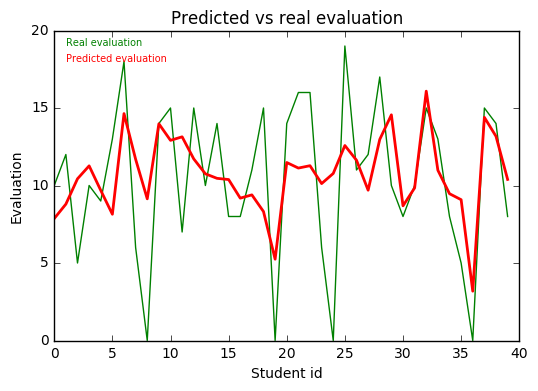

In [11]:
plt.plot(test_y.values, color="green", linewidth=1)
plt.plot(predicted_test, color="red", linewidth=2)
plt.xlabel('Student id')
plt.ylabel('Evaluation')
plt.title('Predicted vs real evaluation')
plt.text(1,19,'Real evaluation', color="green", fontsize=7)
plt.text(1,18,'Predicted evaluation', color="red", fontsize=7)
plt.show()

#### Використовуючи натреновану модель, отримаємо чисельну важливість кожної ознаки та побудуємо гістограму

In [13]:
feature_importance = xgb_model.booster().get_fscore()

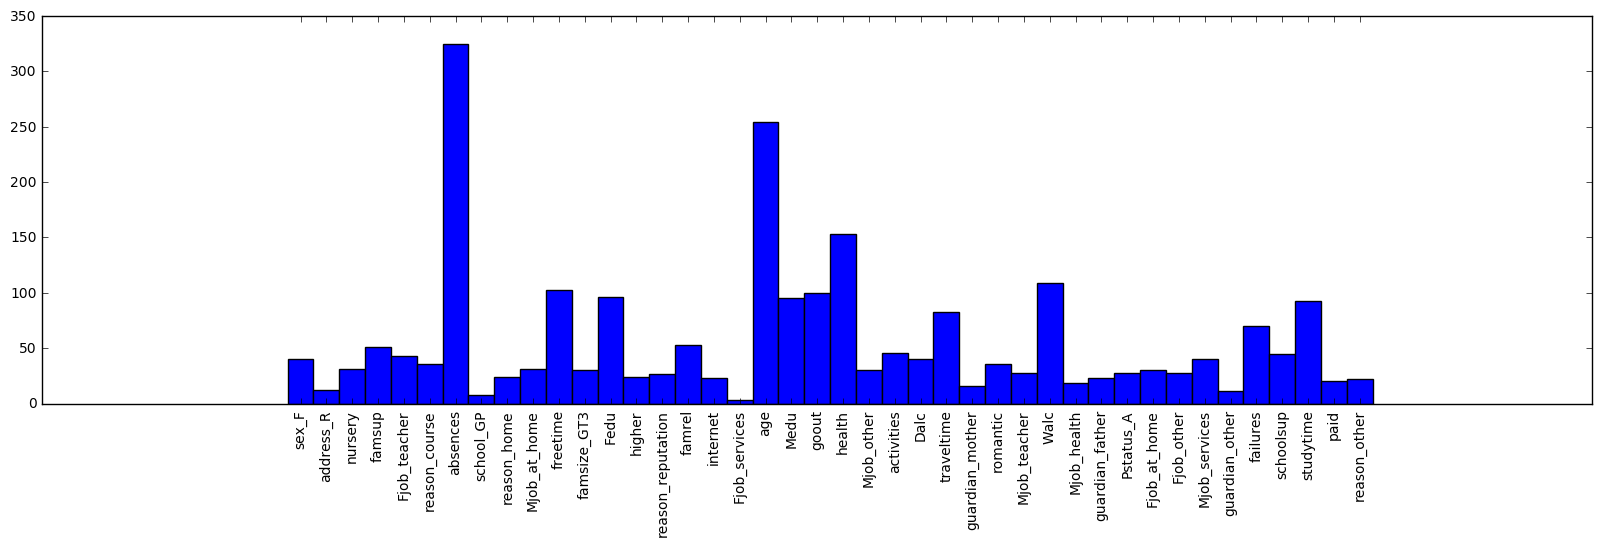

In [14]:
X = np.arange(len(feature_importance))
plt.figure(figsize=(20,5))
plt.bar(X, feature_importance.values(), align='center', width=1)
plt.xticks(X, feature_importance.keys(), rotation=90)
plt.show()

#### Знайдемо 5 найважливіших ознак

In [15]:
Counter(feature_importance).most_common(5)

[('absences', 325),
 ('age', 254),
 ('health', 153),
 ('Walc', 109),
 ('freetime', 103)]

#### Змінимо кількість дерев у моделі в діапазоні від 10 до 300 та порахуємо MAE на тестовій вибірці.

In [16]:
def train_models(trees, maes):
    for tree in trees:
        model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=tree, seed=42).fit(train_X, train_y)
        mae = mean_absolute_error(test_y, model.predict(test_X))
        maes.append(mae)
        print('кількість дерев:', tree, '| середня похибка передбачення:', mae)
        print('----------------------------------------------------------')

In [17]:
trees = np.arange(10, 301, 5)
maes = []
train_models(trees, maes)

кількість дерев: 10 | середня похибка передбачення: 6.60093344152
----------------------------------------------------------
кількість дерев: 15 | середня похибка передбачення: 5.50010842681
----------------------------------------------------------
кількість дерев: 20 | середня похибка передбачення: 4.78385347128
----------------------------------------------------------
кількість дерев: 25 | середня похибка передбачення: 4.29256833792
----------------------------------------------------------
кількість дерев: 30 | середня похибка передбачення: 4.02395173907
----------------------------------------------------------
кількість дерев: 35 | середня похибка передбачення: 3.85046544671
----------------------------------------------------------
кількість дерев: 40 | середня похибка передбачення: 3.730924505
----------------------------------------------------------
кількість дерев: 45 | середня похибка передбачення: 3.60845790505
----------------------------------------------------------
кі

#### Побудуємо графік залежності MAE на тестовій вибірці від кількості дерев

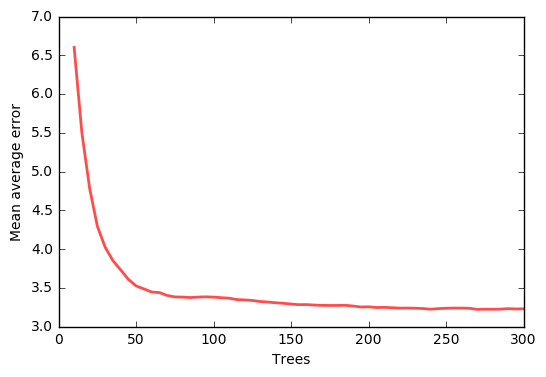

In [18]:
plt.plot(trees,maes, color="red", alpha=0.7, linewidth=2.0)
plt.ylabel('Mean average error')
plt.xlabel('Trees')
plt.show()